<a href="https://colab.research.google.com/github/krogul222/Autoencoders/blob/master/DogVariationalConvolutionalAutoencoderRGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 40s 0us/step


In [0]:
#n_inputs = 32*32

print(np.shape(x_train))

x_train = x_train/255
x_test = x_test/255

x_train_dog_i = np.where(y_train == 5)[0]
x_test_dog_i = np.where(y_test == 5)[0]

x_train = x_train[x_train_dog_i]
x_test = x_test[x_test_dog_i]

print(np.shape(x_train)) 

(50000, 32, 32, 3)
(5000, 32, 32, 3)


In [0]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")  

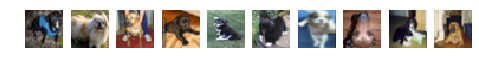

In [0]:
# looping through the first 10 test images and printing  them out

for i in range(10):
    plt.subplot(1, 10, i+1)
    plot_image(x_train[i])
plt.show()

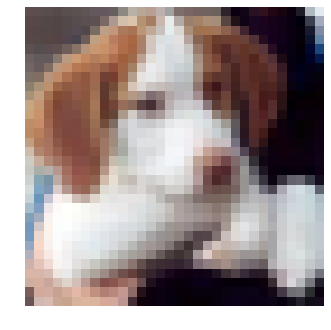

In [0]:
plot_image(x_test[1])

In [0]:


## Parameters

n_inputs = 32
BATCH_SIZE = 150

# using a placeholder

learning_rate = 0.001

n_latent = 128*3

## Define the Xavier initialization
xav_init =  tf.contrib.layers.xavier_initializer()
## Define the L2 regularizer
l2_reg = 0.01
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

## Create the dense layer
dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.leaky_relu,
                         kernel_initializer=xav_init,
                         kernel_regularizer=l2_regularizer)

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs, n_inputs, 3])
batch_size = tf.placeholder(tf.int64)
## Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

#Encoder

# Convolutional Layer #1
e_conv1 = tf.layers.conv2d(inputs=features, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, kernel_initializer=xav_init, kernel_regularizer=l2_regularizer)   # Input: [32,32,3];  Output: [32,32,32]

# Pooling Layer #1
e_pool1 = tf.layers.max_pooling2d(inputs=e_conv1, pool_size=[2, 2], strides=2) # Input: [32,32,32];  Output: [16,16,32]

# Convolutional Layer #2 and Pooling Layer #2
e_conv2 = tf.layers.conv2d(inputs=e_pool1, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, kernel_initializer=xav_init, kernel_regularizer=l2_regularizer) # Input: [16,16,32];  Output: [16,16,16]
e_pool2 = tf.layers.max_pooling2d(inputs=e_conv2, pool_size=[2, 2], strides=2) # Input: [16,16,16];  Output: [8,8,16]

e_conv3 = tf.layers.conv2d(inputs=e_pool2, filters=24, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, kernel_initializer=xav_init, kernel_regularizer=l2_regularizer) # Input: [8,8,16];  Output: [8,8,24]
e_pool3 = tf.layers.max_pooling2d(inputs=e_conv2, pool_size=[2, 2], strides=2) # Input: [8,8,24];  Output: [4,4,24]

flat = tf.layers.flatten(e_conv3)

#flat = tf.reshape(e_pool3, shape=[-1,1])

mn = dense_layer(inputs = flat, units=n_latent)
sd = 0.5 * dense_layer(inputs = flat, units=n_latent)            
epsilon = tf.random_normal(tf.stack([tf.shape(flat)[0], n_latent])) 

z = mn + tf.multiply(epsilon, tf.exp(sd))

post_z = dense_layer(inputs = z, units = n_latent)

post_z = tf.reshape(post_z, shape=[-1, 4, 4, 24])


#Decoder
d_conv1 = tf.layers.conv2d(inputs=post_z, filters=24, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, kernel_initializer=xav_init, kernel_regularizer=l2_regularizer)
d_upsampling1 = tf.image.resize_images(images=d_conv1, size=(8, 8))

d_conv2 = tf.layers.conv2d(inputs=post_z, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, kernel_initializer=xav_init, kernel_regularizer=l2_regularizer)
d_upsampling2 = tf.image.resize_images(images=d_conv2, size=(16, 16))

d_conv3 = tf.layers.conv2d(inputs=d_upsampling2, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, kernel_initializer=xav_init, kernel_regularizer=l2_regularizer)
d_upsampling3 = tf.image.resize_images(images=d_conv3, size=(32, 32))

#output = tf.layers.conv2d(inputs=d_upsampling3, filters=3, kernel_size=[5, 5], padding="same", activation=tf.nn.sigmoid)
flat2 = tf.layers.flatten(d_upsampling3)
output = dense_layer(inputs = flat2, units=32*32*3, activation = tf.nn.sigmoid)
# Loss

img_loss = tf.reduce_sum(tf.squared_difference(output, tf.reshape(features,shape=[-1,32*32*3])), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + 0.1*latent_loss)

optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

num_epoch = 500

## Call Saver to save the model and re-use it later during evaluation
saver = tf.train.Saver()


with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(iter.initializer, feed_dict={x: x_train, batch_size: BATCH_SIZE})
  
  print('Training...')
  print(sess.run(features).shape)
  
  for epoch in range(num_epoch):   
    
    num_batches = x_train.shape[0]//BATCH_SIZE

    for iteration in range(num_batches):
      sess.run(train)
    
    train_loss=loss.eval()
    print("epoch {} loss {}".format(epoch,train_loss))
  save_path = saver.save(sess, "./modelVCADog.ckpt")    
  print("Model saved in path: %s" % save_path)  
  
  
  #num_test_images = 10

  #results = output.eval(feed_dict={x:x_train[:num_test_images]})
    
  #f,a=plt.subplots(2,10,figsize=(20,4))
  #for i in range(num_test_images):
   # a[0][i].imshow(np.reshape( x_train[i],(32,32)), cmap = "Greys_r",interpolation="nearest")
   # a[1][i].imshow(np.reshape(results[i],(32,32)), cmap = "Greys_r",interpolation="nearest")

Training...
(150, 32, 32, 3)
epoch 0 loss 188.1709442138672
epoch 1 loss 157.95103454589844
epoch 2 loss 120.26499938964844
epoch 3 loss 108.71310424804688
epoch 4 loss 96.74445343017578
epoch 5 loss 89.36670684814453
epoch 6 loss 93.9360122680664
epoch 7 loss 90.83329772949219
epoch 8 loss 82.73703002929688
epoch 9 loss 82.80709838867188
epoch 10 loss 79.12303161621094
epoch 11 loss 73.65267944335938
epoch 12 loss 77.45341491699219
epoch 13 loss 75.51724243164062
epoch 14 loss 78.5661849975586
epoch 15 loss 72.1200942993164
epoch 16 loss 73.48746490478516
epoch 17 loss 71.55923461914062
epoch 18 loss 72.90745544433594
epoch 19 loss 73.53577423095703
epoch 20 loss 68.5677719116211
epoch 21 loss 65.58497619628906
epoch 22 loss 69.97522735595703
epoch 23 loss 68.72383117675781
epoch 24 loss 65.86449432373047
epoch 25 loss 67.61685180664062
epoch 26 loss 63.67109298706055
epoch 27 loss 66.3564453125
epoch 28 loss 66.1506576538086
epoch 29 loss 65.56869506835938
epoch 30 loss 62.0318489074

In [0]:
def reconstruct_image(df, image_number = 1):
    ## Part 1: Reshape the image to the correct dimension i.e 1, 1024
    x_test = df[image_number]
    x_test_1 = x_test.reshape((1, 32, 32, 3))
    
    ## Part 2: Feed the model with the unseen image, encode/decode the image
    with tf.Session() as sess:     
        sess.run(tf.global_variables_initializer()) 
        sess.run(iter.initializer, feed_dict={x: x_test_1,
                                      batch_size: 1})
    ## Part 3:  Print the real and reconstructed image
      # Restore variables from disk.
        saver.restore(sess, "./modelVCADog.ckpt")  
        print("Model restored.")
      # Reconstruct image
        outputs_val = output.eval()
        print(outputs_val.shape)
        fig = plt.figure()
      # Plot real
        ax1 = fig.add_subplot(121)
        plot_image(x_test_1.reshape((32, 32, 3)))
      # Plot estimated
        ax2 = fig.add_subplot(122)
        plot_image(outputs_val.reshape((32, 32, 3)))
        plt.tight_layout()
        fig = plt.gcf()

INFO:tensorflow:Restoring parameters from ./modelVCADog.ckpt
Model restored.
(1, 3072)


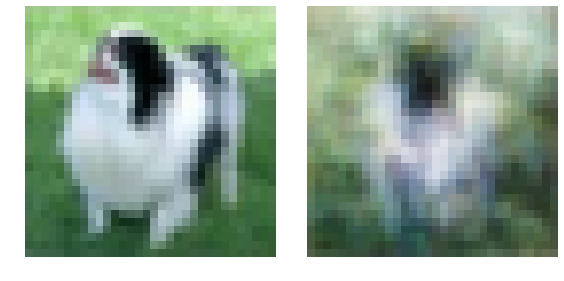

In [0]:
reconstruct_image(df = x_test, image_number = 10)	

In [0]:
import os
print( os.getcwd() )
print( os.listdir('./') )

/content
['.config', 'modelVCADog2.ckpt.meta', 'checkpoint', 'modelVCADog.ckpt.index', 'modelVCADog.ckpt.data-00000-of-00001', 'modelVCADog.ckpt (1).meta', 'modelVCADog.ckpt.meta', 'sample_data']


In [0]:
from google.colab import files
files.download( "./model.ckpt.meta") 

In [0]:
from google.colab import files

uploaded = files.upload()

Saving modelVCADog2.ckpt.meta to modelVCADog2.ckpt.meta
